## Deep MLP for Jet-Images using jet constituents in HLS data
## Author: Andre Sznajder

In [1]:
#!fusermount -u drive
#! pip install einops

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'
#data_dir = '/Users/sznajder/cernbox/WorkM1/tensorflow_macos/arm64/workdir/data/hls4ml_LHCjet_30p_val/'

# Load HLS4ML dataset 

## Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

## https://github.com/pierinim/tutorials/blob/master/GGI_Jan2021/Lecture1/Notebook1_ExploreDataset.ipynb

 * 'jetImage' contains the image representation of the jets (more later)

 * 'jetImageECAL' and 'jetImageHCAL' are the ECAL- and HCAL-only equivalent images. We will not use them (but you are more than welcome to play with it)

 * 'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored

 * 'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList' 'jets' is the dataset we consider for the moment

 * 'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'


In [3]:
import numpy as np
import h5py
import os

TRAIN_PATH = '/Users/sznajder/WorkM1/workdir/data/hls4ml_LHCjet_150p_train/'

# for pT, eta_rel, phi_rel
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[5,8,11]])
# for px, py, pz
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[0,1,2]])
#   myJetConstituentList = np.array(f.get("jetConstituentList"))
#
# Jet Constituents Features =  [0='j1_px', 1='j1_py', 2='j1_pz', 3='j1_e', 4='j1_erel', 5='j1_pt', 6='j1_ptrel',
#                         7='j1_eta', 8='j1_etarel', 9='j1_etarot', 10='j1_phi', 11='j1_phirel', 12='j1_phirot',
#                         13='j1_deltaR', 14='j1_costheta', 15='j1_costhetarel', 16='j1_pdgid']


# Prepare the DATA
#target = np.array([])
#jetConstituent = np.array([])
#jetImage = np.array([])
first=True
for file in os.listdir(TRAIN_PATH):
  print("Appending %s" %file)

  with h5py.File(TRAIN_PATH+file, 'r') as data:
    if first : 
        first=False
        jetConstituent = data['jetConstituentList'][:,:,[5,8,11]]  # 
        jetConstituent = data['jetConstituentList'][:,:,[5,8,11]]  # 
#        jetImage= data['jetImage'][:,:,:] 
        target = data['jets'][:,-6:-1]
    
        print("Keys in H5PY files = ",list( data.keys() ))
        print(" ")
        featurenames = data.get('jetFeatureNames')
        print("Jets Features = ",featurenames[:])
        # the b is due to the byte vs utf-8 encoding of the strings in the dataset
        # just ignore them for the moment
        print(" ")
        featurenames = data.get('particleFeatureNames')
        print("Jet Constituents Features = ",featurenames[:])
        print(" ")
        images = data.get('jetImage')
        print("Jet Images = ",images[:])        
        print("Jet Image Shape = ",images.shape)   
        print(" ")

    else:
         # Read (Pt,Etarel,Phirel)
        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,8,11]] ] , axis=0 )
         # Read (Pt,Eta,Phi)
#        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,7,10]] ] , axis=0 )
#        jetImage = np.concatenate( [ jetImage, data['jetImage']    ] , axis=0 )
        target   = np.concatenate( [ target, data['jets'][:,-6:-1] ] , axis=0 )



                                    
print("Target shape =", target.shape)
print("Jet Constituents shape =", jetConstituent.shape)
print("Jet Constituents type =", type(jetConstituent))
#print("Jet Image shape =", jetImage.shape)



Appending jetImage_6_150p_40000_50000.h5
Keys in H5PY files =  ['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']
 
Jets Features =  [b'j_ptfrac' b'j_pt' b'j_eta' b'j_mass' b'j_tau1_b1' b'j_tau2_b1'
 b'j_tau3_b1' b'j_tau1_b2' b'j_tau2_b2' b'j_tau3_b2' b'j_tau32_b1'
 b'j_tau32_b2' b'j_zlogz' b'j_c1_b0' b'j_c1_b1' b'j_c1_b2' b'j_c2_b1'
 b'j_c2_b2' b'j_d2_b1' b'j_d2_b2' b'j_d2_a1_b1' b'j_d2_a1_b2' b'j_m2_b1'
 b'j_m2_b2' b'j_n2_b1' b'j_n2_b2' b'j_tau1_b1_mmdt' b'j_tau2_b1_mmdt'
 b'j_tau3_b1_mmdt' b'j_tau1_b2_mmdt' b'j_tau2_b2_mmdt' b'j_tau3_b2_mmdt'
 b'j_tau32_b1_mmdt' b'j_tau32_b2_mmdt' b'j_c1_b0_mmdt' b'j_c1_b1_mmdt'
 b'j_c1_b2_mmdt' b'j_c2_b1_mmdt' b'j_c2_b2_mmdt' b'j_d2_b1_mmdt'
 b'j_d2_b2_mmdt' b'j_d2_a1_b1_mmdt' b'j_d2_a1_b2_mmdt' b'j_m2_b1_mmdt'
 b'j_m2_b2_mmdt' b'j_n2_b1_mmdt' b'j_n2_b2_mmdt' b'j_mass_trim'
 b'j_mass_mmdt' b'j_mass_prun' b'j_mass_sdb2' b'j_mass_sdm1'
 b'j_multiplicity' b'j_g' b'j_q' b'j_w' b'j_z' b'

# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)



In [4]:
from einops import rearrange, reduce, repeat

# Convert target format from one-hot encoding to single neuron
#target = np.argmax(target, axis=1)

# The dataset is N_jets x N_particles x N_features
# the IN wants N_jets x N_features x N_particles
#jetList = np.swapaxes(jetList, 1, 2)

# The dataset is N_jets x N_phi x N_eta
# 3D tensor (tensorflow backend)
# 1st dim is jet image index
# 2nd dim is image eta bin
# 3rd dim is image phi bin
njet = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat = jetConstituent.shape[2]

print('Shape of jetConstituent =',jetConstituent.shape)
print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)

print('Pt order of jetConstituent =',jetConstituent[0,:,0])

# Filter out constituents with Pt<2GeV
Ptmin =2. 
constituents = np.zeros((njet, nconstit, nfeat) , dtype=np.float32) 
ij=0
max_constit=0
for j in range(njet):
    ic=0
    for c in range(nconstit):
        if ( jetConstituent[j,c,0] < Ptmin ):
            continue
        constituents[ij,ic,:] = jetConstituent[j,c,:] 
        ic+=1
    if (ic > 0):
        if ic > max_constit: max_constit=ic
        target[ij,:]=target[j,:] # assosicate the correct target a given graph 
        ij+=1


# Resizes the jets constituents and target arrays        
jetConstituent = constituents[0:ij,0:max_constit,:]
target = target[0:ij,:]


# Restric the number of constituents to a maximum of NMAX
nmax = 8
jetConstituent = jetConstituent[:,0:nmax,:]

# The dataset is N_jets x N_constituents x N_features
njet     = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat    = jetConstituent.shape[2]


print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)



# Shuffles jet constituents
print("Before --->> jetConstituent[0,0:4,0] = ",jetConstituent[0,0:4,0])
jetConstituent = jetConstituent[ : , np.random.permutation(nconstit), : ]
print("After --->> jetConstituent[0,0:4,0] = ",jetConstituent[0,0:4,0])




# Flatten the 2D ( eta x phi ) jet image into 1D array to input into a MLP 
jetConstituent = rearrange( jetConstituent , 'batch njet nfeatures -> batch (njet nfeatures)' )  
print('Shape of flattened jetConstituent=',jetConstituent.shape)





Shape of jetConstituent = (620000, 150, 3)
Number of jets = 620000
Number of constituents = 150
Number of features = 3
Pt order of jetConstituent = [118.65740967 113.409935   113.00754547 104.92594147  61.50101852
  53.66347885  45.74335861  39.23477173  29.37190056  22.35709763
  21.92587852  17.52033234  17.42337799  15.18218422  14.11351871
  13.72482491  13.50632286  10.30114079   8.97198772   8.96437454
   8.07441998   7.58543396   7.50657463   7.46961069   6.23603106
   5.9958806    5.94867468   5.80270481   5.797472     5.78151035
   5.74027824   5.22847748   5.22158384   5.01134872   4.77666521
   4.57415247   4.06493235   4.00370693   3.98148799   3.89257169
   3.73196507   3.54980588   3.47391248   3.30842233   3.28169322
   3.13572168   3.02158785   2.85270143   2.67052031   2.46186328
   2.17798376   2.14579487   2.1329205    1.94092917   1.76847756
   1.68797469   1.18708348   1.16993809   1.11563432   1.10890877
   0.98700857   0.86270922   0.8541792    0.79871196   0.665

## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing) 

In [5]:
from sklearn.model_selection import train_test_split

X = jetConstituent
Y = target
del jetConstituent , target

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

print('number of G jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==0 ))
print('number of Q jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==1 ))
print('number of W jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==2 ))
print('number of Z jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==3 ))
print('number of T jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==4 ))


print('number of G jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==0 ))
print('number of Q jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==1 ))
print('number of W jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==2 ))
print('number of Z jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==3 ))
print('number of T jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==4 ))



(415400, 24) (204600, 24) (415400, 5) (204600, 5)
number of G jets for training/validation: 83689
number of Q jets for training/validation: 80676
number of W jets for training/validation: 83507
number of Z jets for training/validation: 83589
number of T jets for training/validation: 83939
number of G jets for testing: 41159
number of Q jets for testing: 39535
number of W jets for testing: 41430
number of Z jets for testing: 41065
number of T jets for testing: 41411


## Define our Deep MLP model


In [9]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras import utils
#from tensorflow.keras import mixed_precision


print("X type=",type(X_train_val))
print("X shape=",X_train_val.shape)

# Define MLP input layer dimension ( NINPUT = neta*nphi )
NINPUT = len(X_train_val[1])
NOUTPUT = len(Y_train_val[1])


input  = Input(shape=(NINPUT,), name = 'input') 

# Define MLP with 2 hidden layers 

'''
# MLP architechture for 32 contituents
hidden = BatchNormalization(momentum=0.1, name='batchnorm')(input)
hidden = Dense(NINPUT/2,  name = 'hidden1', activation='relu')(hidden)
hidden = Dense(NINPUT/10,  name = 'hidden2', activation='relu')(hidden)
'''


'''
# MLP architechture for 16 contituents
hidden = BatchNormalization(momentum=0.1, name='batchnorm')(input)
hidden = Dense(NINPUT*2,  name = 'hidden1', activation='relu')(hidden)
hidden = Dense(NINPUT*2,  name = 'hidden2', activation='relu')(hidden)
'''

# MLP architechture for 8 contituents
hidden = BatchNormalization(momentum=0.1, name='batchnorm')(input)
hidden = Dense(NINPUT*2,  name = 'hidden1', activation='relu')(hidden)
hidden = Dense(NINPUT*2,  name = 'hidden2', activation='relu')(hidden)



output  = Dense(NOUTPUT,   name = 'output',  activation='softmax')(hidden)



# create the model
model = Model(inputs=input, outputs=output)
# Define the optimizer ( minimization algorithm )
#optim = SGD(lr=0.01,decay=1e-6)
optim = Adam(lr=0.0002)
#optim = Adam(lr=0.0005)
#optim = Adam()

# compile the model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


# print the model summary
model.summary()

X type= <class 'numpy.ndarray'>
X shape= (415400, 24)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 24)]              0         
_________________________________________________________________
batchnorm (BatchNormalizatio (None, 24)                96        
_________________________________________________________________
hidden1 (Dense)              (None, 48)                1200      
_________________________________________________________________
hidden2 (Dense)              (None, 48)                2352      
_________________________________________________________________
output (Dense)               (None, 5)                 245       
Total params: 3,893
Trainable params: 3,845
Non-trainable params: 48
_________________________________________________________________


## Run training
Here, we run the training.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# early stopping callback
es = EarlyStopping(monitor='val_categorical_accuracy', patience=10)

# Learning rate scheduler 
lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('mlp_model.h5', monitor='val_categorical_accuracy', 
                       verbose=0, save_best_only=True, 
                       save_weights_only=False, mode='auto', 
                       period=1)


# Train classifier
history = model.fit(  X_train_val, Y_train_val, 
                    epochs=100, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[lr, es, chkp], 
                    validation_split=0.3 )
                    
#                    callbacks=[early_stopping, model_checkpoint], 
                    

Epoch 1/100
568/568 [==============================] - 1s 966us/step - loss: 1.5022 - categorical_accuracy: 0.3345 - val_loss: 1.3232 - val_categorical_accuracy: 0.4616
Epoch 2/100
568/568 [==============================] - 0s 824us/step - loss: 1.2986 - categorical_accuracy: 0.4757 - val_loss: 1.2569 - val_categorical_accuracy: 0.4935
Epoch 3/100
568/568 [==============================] - 0s 825us/step - loss: 1.2410 - categorical_accuracy: 0.5035 - val_loss: 1.2161 - val_categorical_accuracy: 0.5098
Epoch 4/100
568/568 [==============================] - 0s 823us/step - loss: 1.2056 - categorical_accuracy: 0.5173 - val_loss: 1.1818 - val_categorical_accuracy: 0.5252
Epoch 5/100
568/568 [==============================] - 0s 827us/step - loss: 1.1665 - categorical_accuracy: 0.5333 - val_loss: 1.1508 - val_categorical_accuracy: 0.5398
Epoch 6/100
568/568 [==============================] - 0s 821us/step - loss: 1.1420 - categorical_accuracy: 0.5440 - val_loss: 1.1258 - val_categorical_acc

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

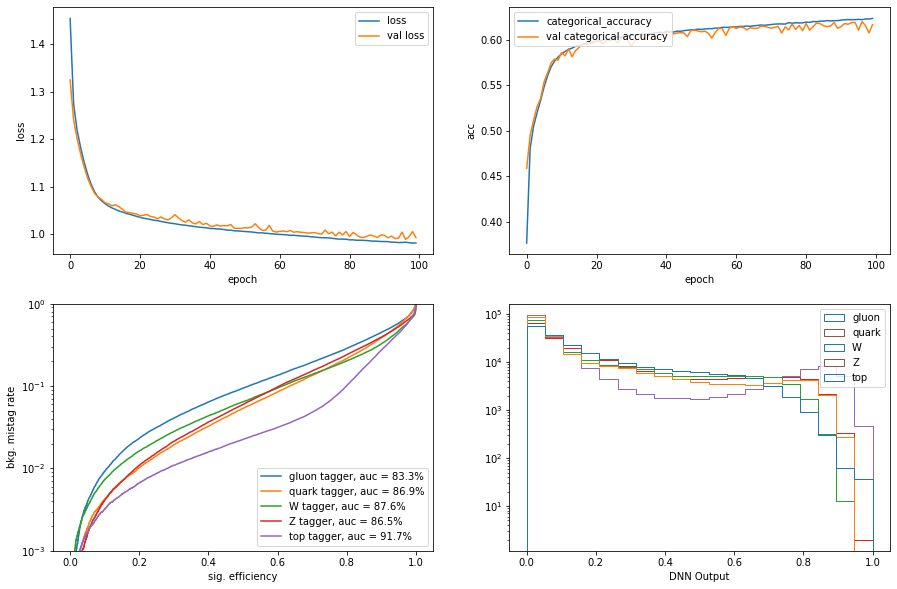

Label =  gluon  with treshold =  0.3
TPR =  0.3000315848295634
FPR =  0.04074253094388801
 
Label =  gluon  with treshold =  0.5
TPR =  0.5001336281250759
FPR =  0.09415630105053199
 
Label =  gluon  with treshold =  0.8
TPR =  0.8000194368181929
FPR =  0.28664778115650297
 
Label =  quark  with treshold =  0.3
TPR =  0.30006323510813204
FPR =  0.01933177839033108
 
Label =  quark  with treshold =  0.5
TPR =  0.5000126470216264
FPR =  0.053548602065852845
 
Label =  quark  with treshold =  0.8
TPR =  0.8000252940432528
FPR =  0.2160966891830491
 
Label =  W  with treshold =  0.3
TPR =  0.30004827419744146
FPR =  0.028056628056628057
 
Label =  W  with treshold =  0.5
TPR =  0.5000482741974415
FPR =  0.06439909297052154
 
Label =  W  with treshold =  0.8
TPR =  0.8000241370987208
FPR =  0.20235950235950237
 
Label =  Z  with treshold =  0.3
TPR =  0.3001582856447096
FPR =  0.021365456935824135
 
Label =  Z  with treshold =  0.5
TPR =  0.5000121758188238
FPR =  0.05977313724890696
 
Labe

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}

ax = plt.subplot(2, 2, 3)
Y_predict = model.predict(X_test)

for i, label in enumerate(labels):
    fpr[label], tpr[label], _ = roc_curve(Y_test[:,i], Y_predict[:,i])
    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
    
ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(loc='lower left')
ax.legend(prop={'size': 10})

# Display plots
plt.show()


# Save FPR for a given TPR value ( 30% , 50% & 80%)
model = 'MLP'
with open('/Users/sznajder/WorkM1/workdir/data/performance_'+model+'_nconst_'+str(nmax)+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( model+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")
               
               
    
    